集成学习是将不同的分类器组合成为一个元分类器，与包含其中的单个分类器相比，元分类器具有更好的泛化能力。集成学习方法采用多数投票原则来得到最终的预测类标，这种原则把大多数分类器预测的结果作为最红的分类类标。

In [5]:
from scipy.special import comb
import math

# 求集成分类器的出错的概率，这里假设每个分类器错误的概率相同
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0) # 返回大于等于函数中参数的整数
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k) for k in range(k_start, n_classifier + 1)]
    # comb(n, m)是求组合数
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

0.03432750701904297

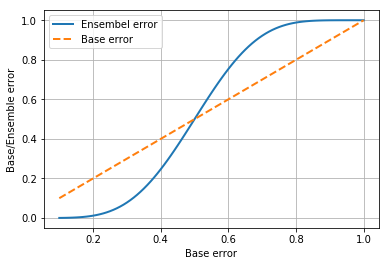

In [6]:
import numpy as np
error_range = np.arange(0.1, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]

import matplotlib.pyplot as plt

plt.plot(error_range, ens_errors, label='Ensembel error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.show()

从图中可以看出，成员分类器的出错率低于随机猜测时，集成分类器的出错率要低于单个分类器。

###  <font color=red>一、实现一个简单的多数投票(majority voting)分类器</font>

如果多数投票分类器中的所有单一分类器的重要性相同，则最终的预测类标由大多数单一分类器预测的类标决定。如果给每一个分类器赋予权重，则最终的预测结果由预测类标的数量乘上权重以后得到的分数决定。

举一个简单的例子，假设三个单一分类器组成多数投票分类器，对某一样本的预测结果是[0, 0, 1]，则在重要性相同的情况下，多数投票分类器的预测结果是类别0。如果三个分类器分别赋予权值[0.2, 0.2, 0.6]，则类别0的分数是0.2 * 2 = 0.4，类别1的分数是1 * 0.6 = 0.6，最终的预测结果是类别1。

In [7]:
import numpy as np

'''
np.argmax()返回数组中最大值的下标
np.bincount()计算数组中整数的个数后乘以权值返回
'''

np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))

1

另一种思路是用预测类别的概率来替代类标

In [8]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

np.argmax(np.average(ex, axis=0, weights=[0.2, 0.2, 0.6]))

0

##### 以下是实现多数投票分类器类的完整代码

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        ''' Fit classifiers
        Parameters
        ----------
        X:{array-like, sparse matrix},
        shape = [n_samples, n_features]
        Matrix of training samples.
        
        y: array-like, shape = [n_samples]
        
            Vector of target class labels.
        Return
        ----------
        self: object
        
        '''
        # Use LabelEncoder to ensure class label start
        # with 0, which is important for np.argmax
        # call in self.predict
        
        self.lablenc_= LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    def predict(self, X):
        '''Predict class label for X
        Parameters
        ----------
        
        X: {array-leke, sparse matrix},
        shape = [n_samples, n_features]
        Matrix of training samples.
        
        Returns
        ----------
        maj_vote: array-like, shape = [n_samples]
            Predicted class labels.
        '''
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
            
        else: 
            # 'classlabel' vote
            # collect retule from clf.predict calls
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    def predict_proba(self, X):
        '''Predict class probabilities for x.
        
        Parameters
        ----------
        X: {array-like, sparse matrix},
            shape = [n_samples, n_feayutes]
            Training vectors, where n_samples is the number of samples
            and n_faetures is the number of features.
            
        Return
        ---------
        avg_proba: array-like,
            shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.
            '''
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        '''Get classfier parameter names for GridSearch'''
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value   
            return out

In [10]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
print(iris.data.shape)
print(iris.target.shape)

X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

(150, 4)
(150,)


In [11]:
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.5, random_state=1)

用训练数据集训练三种不同类型的分类器：logistic回归分类器；决策树分类器以及k-近邻分类器，并且通过10折交叉验证看一下各个分类器在训练数据集上的性能表现。

In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
# 送入决策树的数据不需要标准化处理
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    # cross_val_score()调用k折交叉验证,返回ndarray.shape=(cv,)
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

10-fold cross validation:

ROC AUC: 0.95 (+/- 0.15) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [13]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority Voting']

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('Accuracy: %0.2f (+/- %0.2f) [%s]' % (scores.mean(), scores.std(), label))

Accuracy: 0.95 (+/- 0.15) [Logistic Regression]
Accuracy: 0.92 (+/- 0.15) [Decision Tree]
Accuracy: 0.93 (+/- 0.10) [KNN]
Accuracy: 0.97 (+/- 0.10) [Majority Voting]


评估和优化集成分类器，在测试数据上计算上述代码实现的集成分类器的受试者工作特性曲线(ROC)，以验证其在未知数据上的泛化能力。AUC(Area Under roc Curve)是一种用来度量分类模型好坏的一个标准。顾名思义，AUC的值就是处于ROC曲线下方的那部分面积的大小。通常，AUC的值介于0.5到1.0之间，较大的AUC代表了模型具有较好的性能。

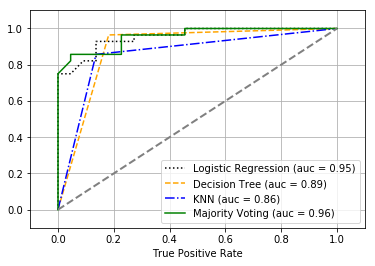

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # 假设正类的标签是1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    # fpr假阳性(假正率)为横轴，tpr真阳性(真正率)为纵轴
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Flase Positive Rate')
plt.xlabel('True Positive Rate')
plt.show()

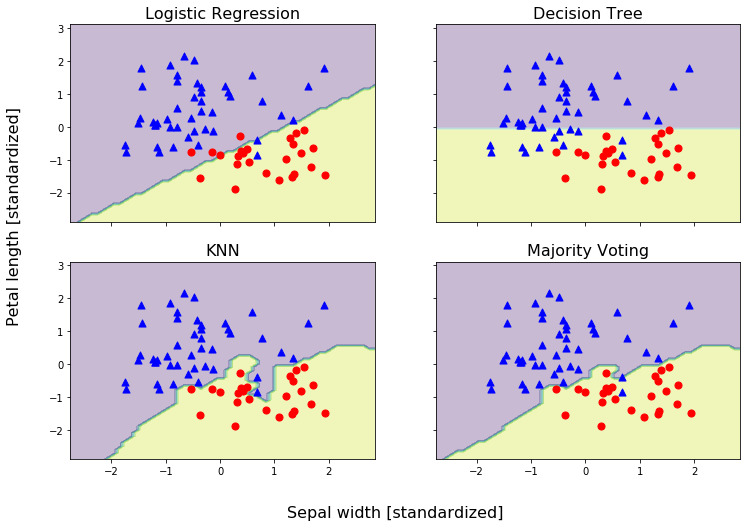

In [37]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# colors = ['lightgreen', 'gray','cyan', 'red', 'blue']
# cmap = ListedColormap(colors[:len(np.unique(y))])

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) # np.meshgrid()函数返回坐标矩阵
fig, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(12, 8))

for idx, clf, lb in zip(product([0, 1], [0, 1]), all_clf, clf_labels):

    clf.fit(X_train_std, y_train)
    # np.c_()将两个数组左右合并，要求行数相等。如果是一维数组，相当于两个列向量合并
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = clf.predict(np.array([xx.ravel(), yy.ravel()]).T) # revel()函数将多维数组进行降维处理返回一维的数组
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)# 绘制等高线(决策区域)
    axarr[idx].scatter(X_train_std[y_train==0, 0], X_train_std[y_train==0, 1], c='blue', marker='^', s=50)
    axarr[idx].scatter(X_train_std[y_train==1, 0], X_train_std[y_train==1, 1], c='red', marker='o', s=50)
    axarr[idx].set_title(lb, fontsize=16)

plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=16)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=16, rotation=90)

plt.show()                     

注：一开始得不到logistic回归模型的决策区域，是因为定义的c值过小(正则化的强度过大)，增大c值后能够正常显示。

网格搜索(10折交叉验证)打印出相应的参数组合以及分数

In [16]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for param, mean, std in zip(grid.cv_results_['params'], grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score']):
    print('%0.3f +/- %0.2f %r' % (mean, std, param))

0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000 +/- 0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [17]:
# 打印出最好的参数组合
print('Best parameters: %s' % grid.best_params_)

# 打印出最好的评估分数
print('Best score: %0.3f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Best score: 1.000


**以上讨论的多数投票集成方法可以称之为<font color=red>堆叠法(stacking)</font>，下面将探讨另外一种集成学习方法：<font color=red>bagging</font>。**

### <font color=green>二、通过bagging算法提高不稳定模型的准确率。</font>

In [18]:
import pandas as pd
df_wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)

In [19]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids',
                  'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines','Proline']
df_wine = df_wine[df_wine['Class label'] !=1 ]
X = df_wine[['Alcohol', 'Hue']].values
y = df_wine['Class label'].values
df_wine.tail()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.7,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.3,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
177,3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [20]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = \
                                train_test_split(X, y, test_size=0.40, shuffle=True, random_state=1)

**从scikit-learn中导入已经实现好的BaggingClassifier类**

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

用单棵决策树来训练模型并且返回训练集和测试集的准确率

In [22]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train) # 拟合训练数据(训练模型)

y_train_pred = tree.predict(X_train) # 返回预测的类标
y_test_pred = tree.predict(X_test)

tree_train_acc = accuracy_score(y_train, y_train_pred)
tree_test_acc = accuracy_score(y_test, y_test_pred)

print('Decision tree\'s train/test accuracy: %0.3f/%0.3f' % (tree_train_acc, tree_test_acc))

Decision tree's train/test accuracy: 1.000/0.854


注：从上述决策树在训练集和测试集的准确率来看，两者相差比较大，模型产生了过拟合。

In [23]:
bag = bag.fit(X_train, y_train)

y_train_pred = bag.predict(X_train) # 返回预测的类标
y_test_pred = bag.predict(X_test)

bag_train_acc = accuracy_score(y_train, y_train_pred)
bag_test_acc = accuracy_score(y_test, y_test_pred)

print('Bagging\'s tree/test accuracy: %0.3f/%0.3f' % (bag_train_acc, bag_test_acc))

Bagging's tree/test accuracy: 1.000/0.896


注：从Bagging分类器得到的准确率看，过拟合程度较之决策树略小。下面从决策区域来比较两者的分类性能。

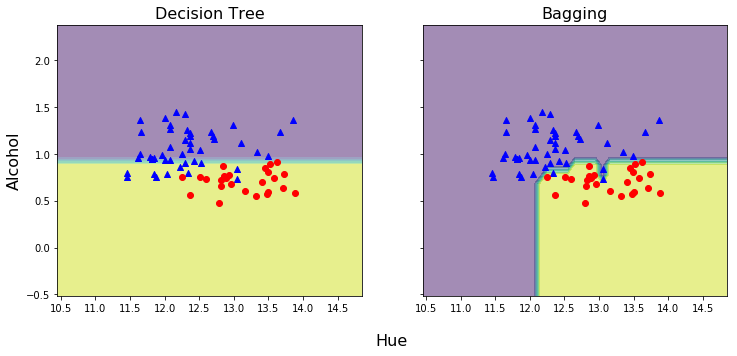

In [35]:
import matplotlib.pyplot as plt
import numpy as np

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) # 返回坐标矩阵

fig, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(12, 5))

clf_ = [tree, bag]
labels_ = ['Decision Tree', 'Bagging']
for idx, clf, lb, in zip([0 ,1], clf_, labels_):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.5)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(lb, fontsize=16)

axarr[0].set_ylabel('Alcohol', fontsize=16)
plt.text(10.0, -1.0, s='Hue', ha='center', va='center', fontsize=16)

plt.show()

### <font color=blue>三、通过自适应boosting(Adaptive Boosting, AdaBoost)提高弱学习机的性能</font>

**boosting**主要针对难以区分的训练样本，也就是说，弱学习机通过在错误分类的样本上的学习来提高分类的性能。与**bagging**不同，boosting的初始化阶段，算法使用无放回抽样从训练样本中的随机抽取一个子集。

自适应boosting(AdaBoost)与原始的boosting过程不同，使用的时整个训练集来训练弱学习机，其中训练样本在每次迭代中都会被重新赋予一个权重，在上一个弱学习机错误的基础上进行学习进而构造一个更加强大的分类器。AdaBoost算法可以概括为以下伪代码：  

(1)以等值的方式为权重向量w赋值，其中$\sum_{i} w_{i}=1$。  
(2)在m轮boosting操作中，对第j轮做如下的操作：  
&emsp;&emsp;1)训练一个加权的弱学习机：$C_{j}=\operatorname{train}(\boldsymbol{X}, \boldsymbol{y}, \boldsymbol{w})$。  
&emsp;&emsp;2)预测样本类标：$\hat{y}=\operatorname{predict}\left(C_{j}, \boldsymbol{X}\right)$。  
&emsp;&emsp;3)计算权重错误率：$\varepsilon=w \cdot(\hat{y}==y)$。  
&emsp;&emsp;4)计算相关系数：$\alpha_{j}=0.5 \log \frac{1-\varepsilon}{\varepsilon}$。  
&emsp;&emsp;5)更新权重：$w :=w \times \exp \left(-\alpha_{j} \times \hat{y} \times y\right)$。  
&emsp;&emsp;6)归一化权重：使其和为1，$w :=w / \sum_{i} w_{i}$。  
(3)完成最后的预测：$\hat{y}=\left(\sum_{j=1}^{m}\left(\alpha_{j} \times \operatorname{predict}\left(C_{j}, \boldsymbol{X}\right)\right)>0\right)$。


该算法在训练开始前，给训练集中的每个样本初始化一个等值的权重，然后开始第一轮训练。根据模型的预测结果计算权重错误率以及相关系数，用计算的结果对权值进行更新，归一化权重以后又开始下一轮的训练。训练的轮次是超参数，设置的标准可以是模型的准确率达到某个理想值。每一轮训练后计算得到的相关系数需要保存下来，在最后的多数投票预测环节当作权重来使用。

**以下代码实现了基于scikit-learn库训练一个AdaBoost集成分类器**

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
abc = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train) # 返回预测的类标
y_test_pred = tree.predict(X_test)
tree_train_acc = accuracy_score(y_train, y_train_pred)
tree_test_acc = accuracy_score(y_test, y_test_pred)
print('Decision tree\'s train/test accuracy: %0.3f/%0.3f' % (tree_train_acc, tree_test_acc))

Decision tree's train/test accuracy: 0.845/0.854


In [27]:
abc.fit(X_train, y_train)
y_train_pred = abc.predict(X_train) # 返回预测的类标
y_test_pred = abc.predict(X_test)
abc_train_acc = accuracy_score(y_train, y_train_pred)
abc_test_acc = accuracy_score(y_test, y_test_pred)
print('AdaBoost\'s train/test accuracy: %0.3f/%0.3f' % (abc_train_acc, abc_test_acc))

AdaBoost's train/test accuracy: 1.000/0.875


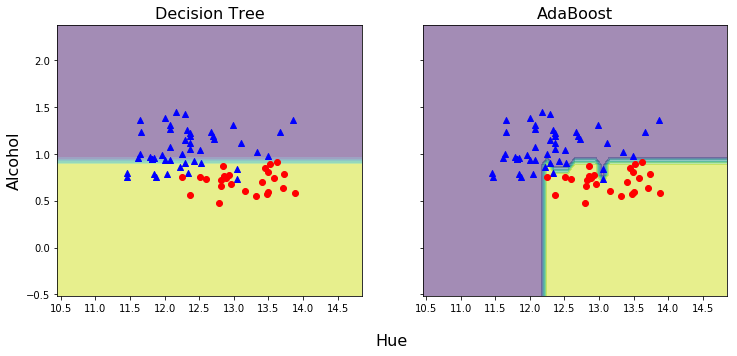

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1)) # 返回坐标矩阵

fig, axarr = plt.subplots(nrows=1, ncols=2, sharex='col', sharey='row', figsize=(12, 5))

clf_ = [tree, abc]
labels_ = ['Decision Tree', 'AdaBoost']
for idx, clf, lb, in zip([0 ,1], clf_, labels_):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    axarr[idx].contourf(xx, yy, Z, alpha=0.5)
    axarr[idx].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    axarr[idx].set_title(lb, fontsize=16)

axarr[0].set_ylabel('Alcohol', fontsize=16)
plt.text(10.0, -1.0, s='Hue', ha='center', va='center', fontsize=16)

plt.show()

总结：从以上探讨的内容可以得出结论，集成分类器的性能较之单独分类器有明显的提升，但是相应的需要付出更多的计算成本。在工程问题上不仅需要考虑分类的准确性，还需要考虑工程实现的复杂性和成本。我们用Python实现了一个MajorityVoteClassifier类，它可以通过组合不同的算法得到一个分类器。进而我们学习了bagging，它能够在训练集上通过bootstrap进行随机抽样，并以多数投票为准则组合多个单独训练的成员分类器，成为一种能够有效降低模型方差的模型。然后我们讨论了AdaBoost，它是一种基于弱学习机的算法，能够从前一个弱学习机错误中进行学习。